In [3]:
!pip install scikeras tensorflow skorch torch | grep -v 'Requirement already satisfied'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 7.2 MB/s eta 0:00:00


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from skorch import NeuralNetRegressor
from tensorflow.keras import callbacks, layers, Sequential 

In [5]:
filepath = "/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv"

df = pd.read_csv(filepath, parse_dates = ['Time'])

df['weather_type'] = df['weather_type'].astype('category')

display(df.sample(5))

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
169119,2021-11-05 15:45:00,0,0.0,8.5,1017,83,4.5,0.0,0.0,53,0,0,555,0.00,3,15,11
103441,2019-12-20 12:15:00,1787,38.6,9.8,996,83,4.2,0.0,0.0,3,1,315,450,0.70,1,12,12
122996,2020-07-11 05:00:00,467,47.9,11.2,1018,90,4.6,0.0,0.0,91,1,150,1005,0.15,4,5,7
32397,2017-12-09 11:15:00,172,8.5,1.0,1002,90,7.4,0.0,0.0,100,1,270,465,0.58,4,11,12
85170,2019-06-12 04:30:00,374,36.1,17.4,1010,84,2.9,0.0,0.0,100,1,135,1020,0.13,4,4,6


In [6]:
numeric_features = ['Energy delta[Wh]', 'GHI', 'pressure', 'humidity',
       'wind_speed', 'rain_1h', 'snow_1h', 'clouds_all',
       'sunlightTime', 'dayLength', 'SunlightTime/daylength',
       'hour', 'month']

categorical_features = ['weather_type']

In [7]:
preprocessor = ColumnTransformer([
                    ('numeric', MinMaxScaler(), numeric_features), 
                    ('categorical', OneHotEncoder(handle_unknown = "ignore"), categorical_features)
               ])

In [8]:
X = df.drop(columns = ['temp', 'Time'])
y = df.temp

In [9]:
X_transformed = pd.DataFrame(preprocessor.fit_transform(X))

In [10]:
display(X_transformed.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000,196776.000000
mean,0.114145,0.142219,0.547040,0.741161,0.275367,0.008163,0.002535,0.659744,0.207570,0.523937,0.265187,0.499952,0.481666,0.142172,0.180042,0.160894,0.371001,0.145892
std,0.208132,0.227627,0.136940,0.200057,0.127391,0.034476,0.024720,0.366286,0.268532,0.341878,0.329023,0.300952,0.306915,0.349227,0.384224,0.367434,0.483074,0.352999
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.471429,0.615385,0.181818,0.000000,0.000000,0.340000,0.000000,0.210526,0.000000,0.217391,0.181818,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.006981,0.557143,0.794872,0.258741,0.000000,0.000000,0.820000,0.029412,0.552632,0.050000,0.478261,0.454545,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.114940,0.204188,0.628571,0.897436,0.349650,0.000000,0.000000,1.000000,0.382353,0.842105,0.530000,0.739130,0.727273,0.000000,0.000000,0.000000,1.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [11]:
train_X, test_X, train_y, test_y = train_test_split(X_transformed, y, 
                                                    random_state = 1, test_size = 0.6
                                                   )

In [12]:
ts_X, val_X, ts_y, val_y = train_test_split(test_X, test_y, test_size = 0.5, random_state = 1)

In [13]:
early_stopping = callbacks.EarlyStopping(patience = 10)

In [14]:
model = Sequential([
            layers.Dense(256, input_shape = [X_transformed.shape[1]], activation = 'relu'), 
            layers.Dense(128, activation = 'relu'),
            layers.Dense(64, activation = 'relu'),
            layers.Dense(64, activation = 'relu'),
            layers.Dense(16),
            layers.Dense(1)
        ])

model.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [15]:
neural_net = KerasRegressor(model, 
                            callbacks = [early_stopping],
                            epochs = 424,
                            batch_size = 64,
                            random_state = 1,
                            verbose = 0
                           )

In [16]:
neural_net.fit(train_X, train_y)

y_train_pred = neural_net.predict(train_X)
y_test_pred = neural_net.predict(ts_X)

print(f"Neural Network train r2 score = {r2_score(train_y, y_train_pred)}")
print(f"Neural Network test r2 score = {r2_score(ts_y, y_test_pred)}")

Neural Network train r2 score = 0.9805687431832278
Neural Network test r2 score = 0.9554696096976494


In [18]:
y_val_pred = neural_net.predict(val_X)

print(f"Neural Network val r2 score = {r2_score(y_val_pred, val_y)}")

Neural Network val r2 score = 0.9543571558495432


In [14]:
ts_df = df[['Time', 'temp', 'Energy delta[Wh]']].copy()

ts_df['date'] = pd.to_datetime(ts_df['Time'].dt.date)

ts_df = ts_df.drop(columns = ['Time'])

display(ts_df.head(10))

,temp,Energy delta[Wh],date
0,1.6,0,2017-01-01
1,1.6,0,2017-01-01
2,1.6,0,2017-01-01
3,1.6,0,2017-01-01
4,1.7,0,2017-01-01
5,1.7,0,2017-01-01
6,1.7,0,2017-01-01
7,1.7,0,2017-01-01
8,1.9,0,2017-01-01
9,1.9,0,2017-01-01


In [15]:
dates_df = ts_df.groupby(['date'])[['temp', 'Energy delta[Wh]']].agg([max, min, np.mean])

dates_df = dates_df.reset_index()

dates_df.columns = ['date', 
                    'max_temp', 'min_temp', 'avg_temp',
                    'max_energy', 'min_energy', 'avg_energy'
                   ]

dates_df.drop(columns = ['min_energy'], inplace = True)

display(dates_df)

,date,max_temp,min_temp,avg_temp,max_energy,avg_energy
0,2017-01-01,3.9,1.6,2.975000,161,21.239583
1,2017-01-02,2.5,-2.2,0.850000,2115,107.364583
2,2017-01-03,4.7,-2.3,1.420833,155,23.500000
3,2017-01-04,2.8,-1.3,1.166667,458,41.125000
4,2017-01-10,-2.0,-7.8,-3.854167,2706,274.072917
...,...,...,...,...,...,...
2045,2022-08-27,26.6,17.1,21.191667,3675,1001.906250
2046,2022-08-28,22.0,13.2,18.829167,1700,207.145833
2047,2022-08-29,20.8,12.9,16.525000,3449,428.510417
2048,2022-08-30,19.8,11.6,16.191667,3953,840.208333


In [16]:
display(dates_df.describe())

,date,max_temp,min_temp,avg_temp,max_energy,avg_energy
count,2050,2050.000000,2050.000000,2050.000000,2050.000000,2050.000000
mean,2019-10-29 13:53:47.707316992,13.673171,5.567659,9.791176,2766.460976,573.081064
min,2017-01-01 00:00:00,-7.400000,-16.600000,-11.129167,11.000000,0.645833
25%,2018-06-02 06:00:00,6.600000,0.625000,3.976042,1314.000000,163.156250
50%,2019-10-28 12:00:00,13.700000,5.200000,9.587500,3387.000000,559.734375
75%,2021-03-23 18:00:00,20.600000,10.800000,15.922917,4030.750000,945.955729
max,2022-08-31 00:00:00,35.800000,21.100000,27.691667,5020.000000,1390.166667
std,NaN,8.696883,6.389209,7.390871,1493.330730,413.750665


In [17]:
date_X = pd.DataFrame(dates_df[['date']].index)
date_y = dates_df.drop(columns = ['date'])

In [18]:
nn_scaler = StandardScaler()

In [19]:
X_prep = StandardScaler().fit_transform(date_X)
y_prep = pd.DataFrame(nn_scaler.fit_transform(date_y))
y_prep.columns = date_y.columns

In [20]:
display(y_prep.describe())

,max_temp,min_temp,avg_temp,max_energy,avg_energy
count,2.050000e+03,2.050000e+03,2.050000e+03,2.050000e+03,2.050000e+03
mean,-2.564886e-16,-6.238912e-17,-2.079637e-16,-1.733031e-17,-6.932124e-17
std,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00,1.000244e+00
min,-2.423663e+00,-3.470393e+00,-2.831256e+00,-1.845628e+00,-1.383865e+00
25%,-8.134979e-01,-7.737835e-01,-7.869916e-01,-9.728691e-01,-9.909950e-01
50%,3.085682e-03,-5.755771e-02,-2.756453e-02,4.156416e-01,-3.226568e-02
75%,7.966670e-01,8.191339e-01,8.298395e-01,8.468302e-01,9.014261e-01
max,2.544846e+00,2.431620e+00,2.422564e+00,1.509437e+00,1.975308e+00


In [45]:
def get_train(X, y, size = 0.5):
    index = int(len(X) * size)
    
    return X[:index], y[:index]

In [87]:
def plot_predictions(dates_df, results, model_name):
    targets = y_prep.columns

    fig, axes = plt.subplots(targets.shape[0], 1, figsize = (10, 35))

    for idx, target in enumerate(targets):

        sns.lineplot(x = dates_df.date, y = dates_df[target], color = 'Blue', ax = axes[idx])
        sns.lineplot(x = dates_df.date, y = results[:, idx], color = 'Green', ax = axes[idx])

        axes[idx].set_title(f"{model_name} prediction for {target}")

    plt.show()

In [21]:
seq_len = 20

In [81]:
lstm_neural_net = Sequential([
                    layers.Dense(256, input_shape = [1], activation = 'relu'),
#                     layers.LSTM(8, stateful = True, batch_input_shape = (5, 32, 1)),
                    layers.Dense(16, activation = 'relu'),
                    layers.Dense(8, activation = 'relu'),
                    layers.Dense(4, activation = 'relu'),
                    layers.Dense(y_prep.shape[1])
#                     layers.Dense(1)
                  ])

In [82]:
lstm_neural_net.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

In [83]:
ts_hist = lstm_neural_net.fit(*get_train(X_prep, y_prep))    

33/33 [==============================] - 1s 2ms/step - loss: 1.0261 - mae: 0.8771


In [90]:
results = nn_scaler.inverse_transform(lstm_neural_net.predict(X_prep))

65/65 [==============================] - 0s 2ms/step


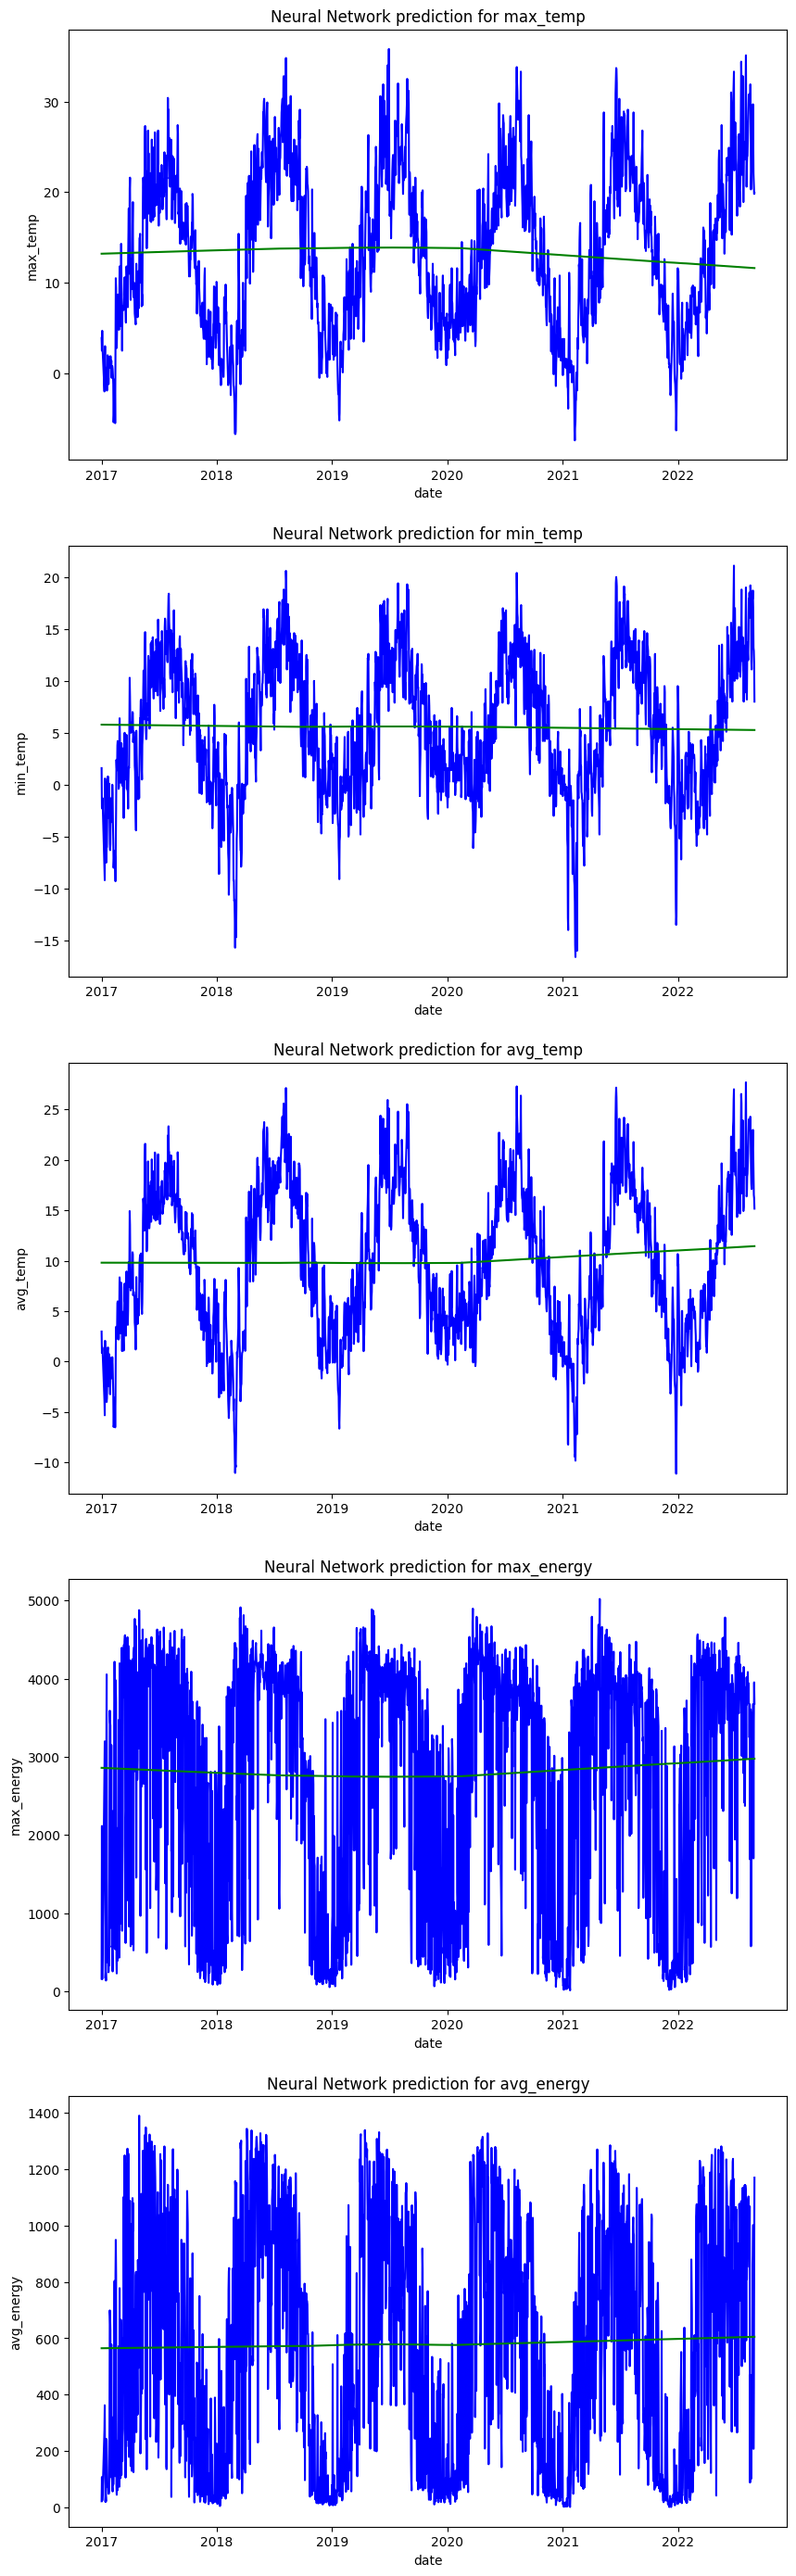

In [86]:
plot_predictions(dates_df, results, 'Neural Network')

In [141]:
lgbr_model = LGBMRegressor(n_estimators = 144, 
                           max_leaf_nodes = 11,
                           learning_rate = 0.12
                          )

lgbr_model = MultiOutputRegressor(lgbr_model)

In [142]:
lgbr_model.fit(*get_train(date_X, date_y))

[LightGBM] [Warning] num_leaves is set=31, max_leaf_nodes=11 will be ignored. Current value: num_leaves=31


MultiOutputRegressor(estimator=LGBMRegressor(learning_rate=0.12,
                                             max_leaf_nodes=11,
                                             n_estimators=144))

In [139]:
lgbr_results = lgbr_model.predict(date_X)

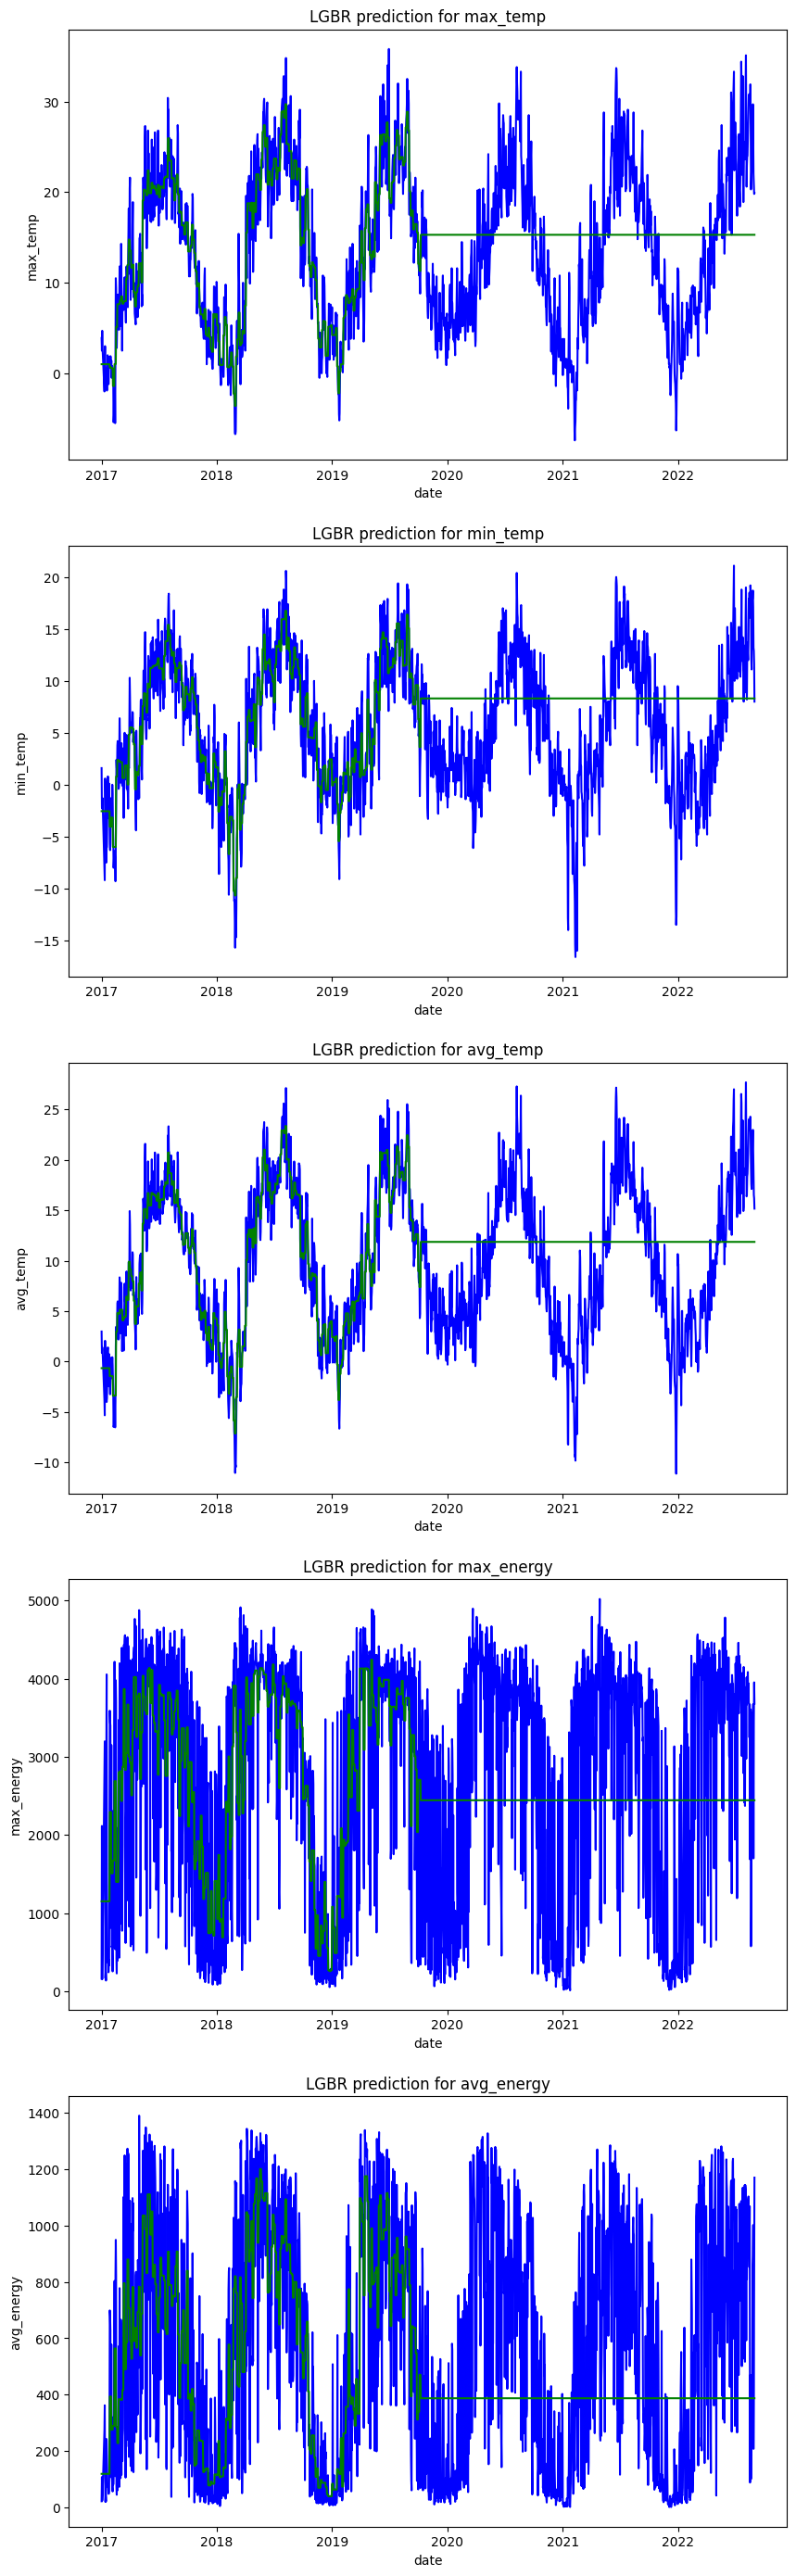

In [143]:
plot_predictions(dates_df, lgbr_results, 'LGBR')